# VALORES ENSO X ALIMENTOS

In [1]:
# Libraries
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.metrics import r2_score
import dateutil.parser

C:\Users\Usuario\AppData\Local\Temp\ipykernel_7216\1914011033.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ex['datetime'] = pd.to_datetime(df_ex['datetime'], format='%Y-%m-%d')


Cantidad de observaciones: 229


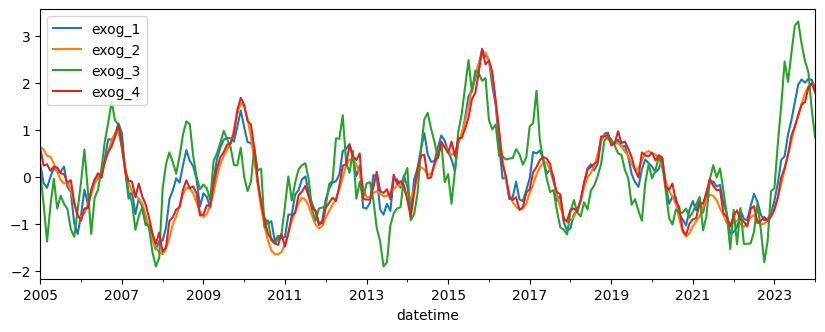

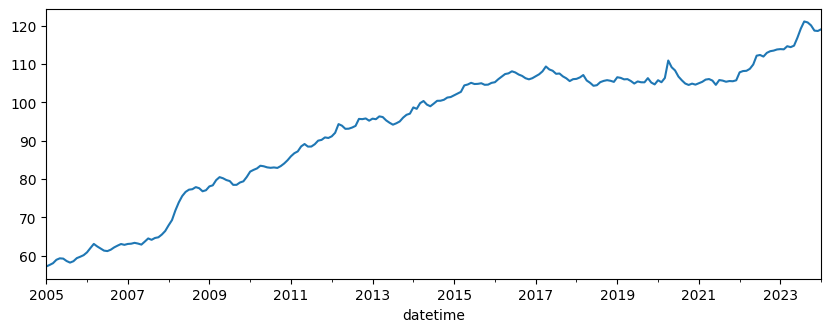

In [2]:
catalog_name = 'UNION_2'
filename = "C:\\Users\\Usuario\\Documents\\UDLA\\Proyecto MBD\\NOAA_ENSO_v2.xlsx" 
df = pd.read_excel(filename,sheet_name=catalog_name)
df.rename({'FECHA_F1':'datetime',
           'Division_01_Alimentos':'y',
           'ANOM3':'exog_1',
           'ONI_ANOM':'exog_2',
           'ANOM12':'exog_3',
           'ANOM34':'exog_4'
           }, axis=1, inplace=True)

df_ex = df[['datetime', 'exog_1','exog_2','exog_3','exog_4']]  
df_ex['datetime'] = pd.to_datetime(df_ex['datetime'], format='%Y-%m-%d')
df_ex = df_ex.set_index('datetime')
df_ex = df_ex.asfreq('MS')
df_ex = df_ex.sort_index()
# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(10, 3.5))
df_ex.plot(ax=ax);

df = df[['datetime','y','exog_1','exog_2','exog_3','exog_4']]
df = df[df['y'].isnull() == 0]
df = df[df['exog_2'].isnull() == 0]
print('Cantidad de observaciones:',len(df))
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d')
df = df.set_index('datetime')
df = df.asfreq('MS')
df = df.sort_index()
# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(10, 3.5))
df['y'].plot(ax=ax);

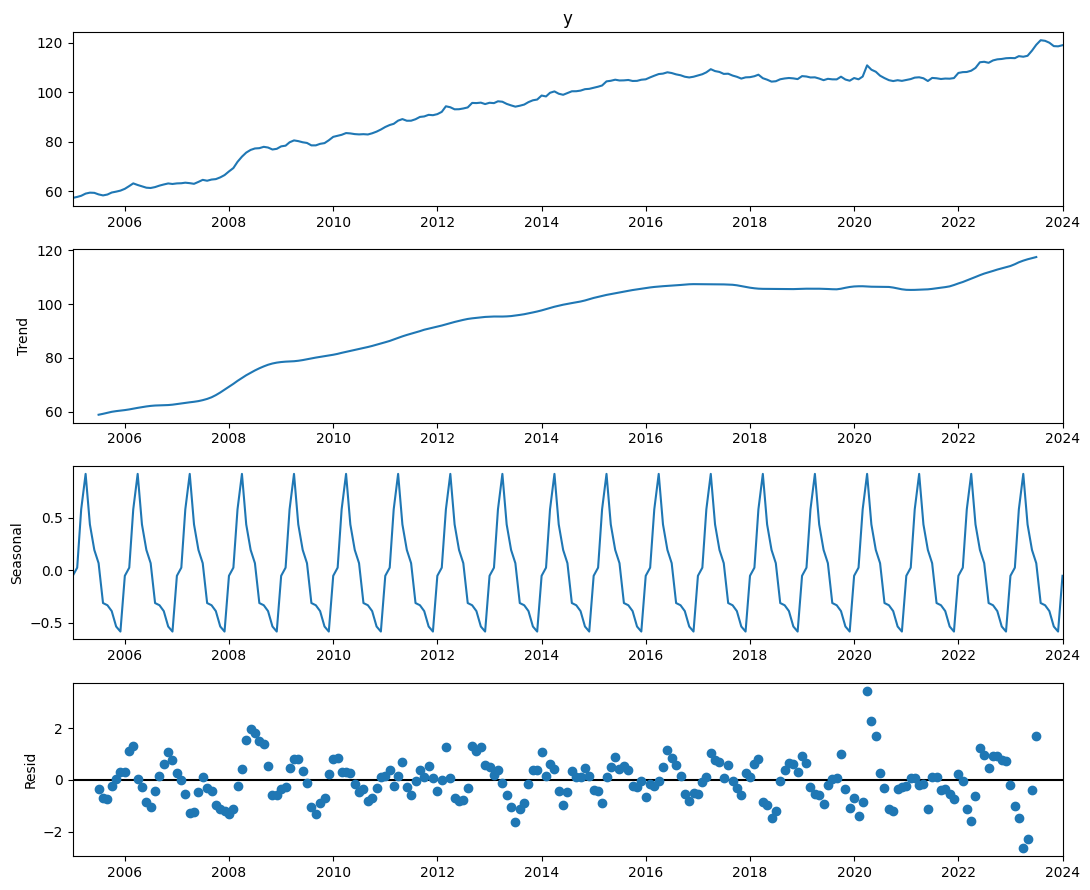

In [3]:
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9
season_IPC = seasonal_decompose(df['y'], model='additive', period=12)
season_IPC.plot()
plt.show()

In [4]:
from statsmodels.tsa.stattools import adfuller
resp_adf = adfuller(df["y"])
print("PRUEBA DE RAIZ UNITARIA: IPC alimentos")
print('ADF Statistic: %f' % resp_adf[0])
print('p-value: %f' % resp_adf[1])
print('Critical Values:')
for key, value in resp_adf[4].items():
    print('\t%s: %.3f' % (key, value))

df_dif1 = pd.DataFrame()
df_dif1['y'] = df.y.diff().bfill()
resp_adf = adfuller(df_dif1)
print("PRUEBA DE RAIZ UNITARIA: DIPC alimentos")
print('ADF Statistic: %f' % resp_adf[0])
print('p-value: %f' % resp_adf[1])
print('Critical Values:')
for key, value in resp_adf[4].items():
    print('\t%s: %.3f' % (key, value))

print("PRUEBA DE RAIZ UNITARIA: ANOMALIA TSM REGION 3.4")
resp_adf = adfuller(df["exog_4"])
print('ADF Statistic: %f' % resp_adf[0])
print('p-value: %f' % resp_adf[1])
print('Critical Values:')
for key, value in resp_adf[4].items():
    print('\t%s: %.3f' % (key, value))


PRUEBA DE RAIZ UNITARIA: IPC alimentos
ADF Statistic: -1.990894
p-value: 0.290580
Critical Values:
	1%: -3.460
	5%: -2.875
	10%: -2.574
PRUEBA DE RAIZ UNITARIA: DIPC alimentos
ADF Statistic: -6.077778
p-value: 0.000000
Critical Values:
	1%: -3.460
	5%: -2.875
	10%: -2.574
PRUEBA DE RAIZ UNITARIA: ANOMALIA TSM REGION 3.4
ADF Statistic: -4.588986
p-value: 0.000135
Critical Values:
	1%: -3.460
	5%: -2.875
	10%: -2.574


In [5]:
# ==============================================================================
perc = 0.057
steps = int(len(df)*perc)
df_train = df.iloc[:-steps, :]
df_test  = df.iloc[-steps:, :]
print("TAMAÑO DATOS ENTRENAMIENTO:",len(df_train))
print("TAMAÑO DATOS PRUEBA:",len(df_test))


TAMAÑO DATOS ENTRENAMIENTO: 216
TAMAÑO DATOS PRUEBA: 13


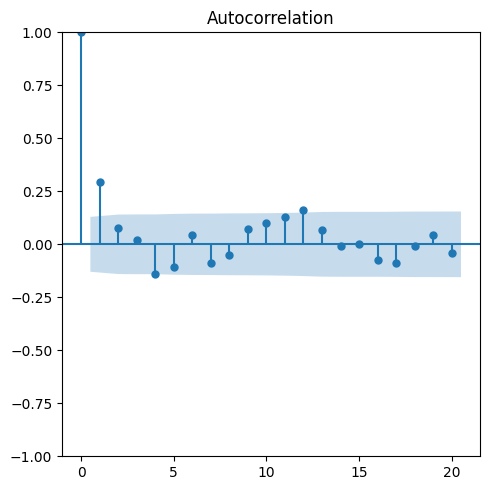

In [6]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.rcParams["figure.figsize"] = (5,5)
plot_acf(df_dif1, lags=20)
plt.tight_layout()

c:\Users\Usuario\Documents\noux_python\proyecto_innovacion\env39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


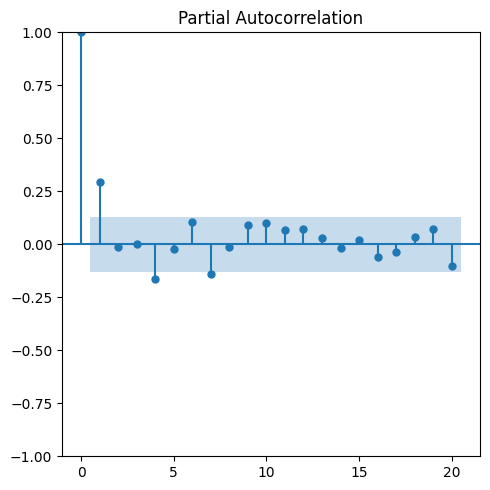

In [7]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.rcParams["figure.figsize"] = (5,5)
plot_pacf(df_dif1, lags=20)
plt.tight_layout()

In [8]:
import statsmodels.api as sm
# ==============================================================================
p,d,q=2,1,2
P,D,Q=2,0,2
trend1=None
modelo_sarimax =sm.tsa.SARIMAX(df_train['y'],exog=df_train[['exog_4']] ,order=(p,d,q),seasonal_order=(P,D,Q, 12),trend=trend1)
rest_sarimax=modelo_sarimax.fit(maxiter=800)
print(rest_sarimax.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  216
Model:             SARIMAX(2, 1, 2)x(2, 0, 2, 12)   Log Likelihood                -232.285
Date:                            Wed, 21 Feb 2024   AIC                            484.570
Time:                                    17:24:04   BIC                            518.276
Sample:                                01-01-2005   HQIC                           498.188
                                     - 12-01-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
exog_4         0.3226      0.194      1.662      0.096      -0.058       0.703
ar.L1          1.0178      0.077   

In [9]:
#Prueba de correlacion en los residuos
sm.stats.acorr_ljungbox(rest_sarimax.resid, lags=[1,2,6,9,40,60,78], return_df=True)


,lb_stat,lb_pvalue
1,0.015240,0.901751
2,0.020874,0.989617
6,0.100317,0.999980
9,0.160175,1.000000
40,1.286307,1.000000
60,1.876430,1.000000
78,2.195442,1.000000


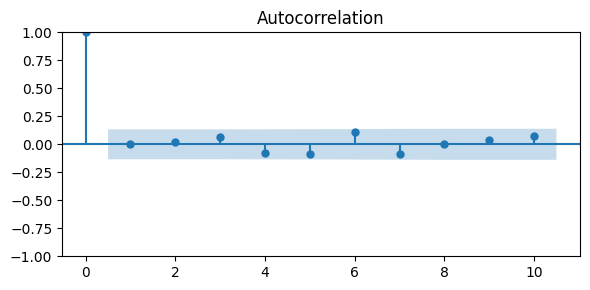

In [10]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.rcParams["figure.figsize"] = (6,3)
plot_acf(rest_sarimax.resid.iloc[d:], lags=10)  
plt.tight_layout() 

In [11]:
# Predict
# ==============================================================================
steps = int(len(df)*perc)
print(steps)
predictions = rest_sarimax.forecast(
                  steps = steps
                  ,exog = df_test[['exog_4']]
              )

13


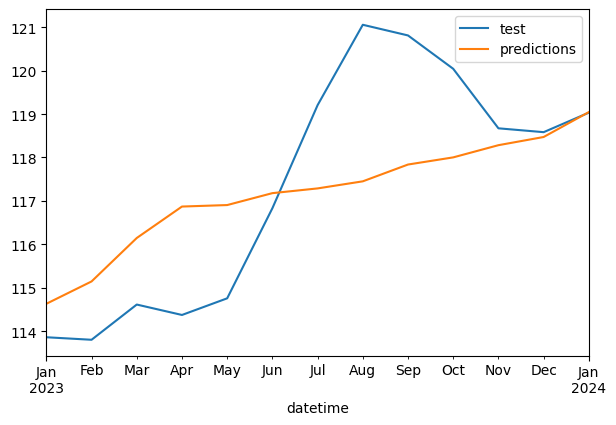

In [12]:
# Plot predictions
# ==============================================================================
fig, ax=plt.subplots(figsize=(7, 4.5))
df_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [13]:
# ==============================================================================
error_mse = mean_squared_error(
                y_true = df_test['y'],
                y_pred = predictions
            )

print("Coeficiente de determinacion: %.3f" % r2_score(df_test['y'], predictions)  )
print(f"MSE: {error_mse}")
print(f"MAE: { mean_absolute_error(y_true =  df_test['y'], y_pred = predictions ) }")


Coeficiente de determinacion: 0.497
MSE: 3.509101680010465
MAE: 1.5155182937083997


### ERROR PARA EL MODELO ESTAR

In [14]:
datastar = [
['2023-01-01',  113.6994056685825],
['2023-02-01',  113.4147089621443],
['2023-03-01',  114.2583239137764],
['2023-04-01',  115.4048135383679],
['2023-05-01',  116.6867783364025],
['2023-06-01',  117.6095111922023],
['2023-07-01',  118.076543916065],
['2023-08-01',  119.0888217053382],
['2023-09-01',  119.6333814135146],
['2023-10-01',  119.7019946704342],
['2023-11-01',  119.6827167667496],
['2023-12-01',  118.5798870780914],
['2024-01-01',  118.6736176872593]
]
datastar = pd.DataFrame(datastar,columns=['fecha','forecast'])
datastar['fecha'] = pd.to_datetime(datastar['fecha'])
datastar = datastar.set_index('fecha') 
preddd= datastar['forecast'].squeeze()
error_star_mse = mean_squared_error(
                y_true =  df_test['y'],
                y_pred = preddd
            )
 
print("Coeficiente de determinacion: %f" % r2_score(df_test['y'],preddd)  )
print(f"MSE: {error_star_mse}")


Coeficiente de determinacion: 0.850987
MSE: 1.0401144629771812


### COMPARACION DE VARIANZA SARIMAX VS ESTAR

In [15]:
SARIMA_r2= r2_score(df_test['y'], predictions)
STAR_R2 = r2_score(df_test['y'],preddd)
print(f'Modelo STAR explica {(STAR_R2 /SARIMA_r2-1)*100:.3f}% mas de variabilidad de los datos del IPC') 

Modelo STAR explica 71.133% mas de variabilidad de los datos del IPC


### GRAFICO DE LINEAS PREDICCIONES DEL MODELO SARIMAX VS ESTAR

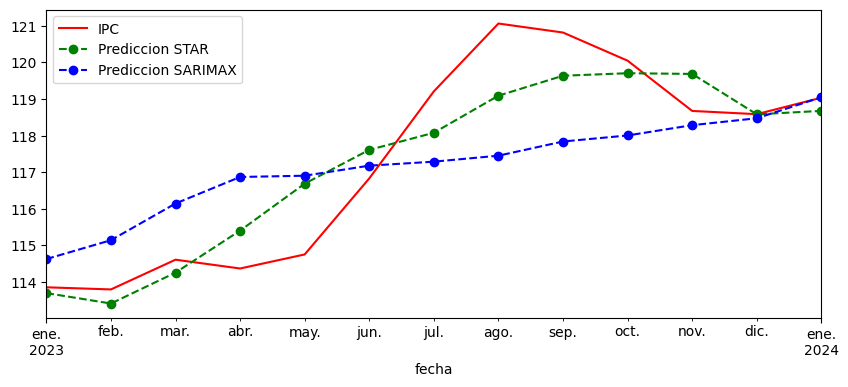

In [16]:
 # Plot predictions
# ==============================================================================
import locale
locale.setlocale(locale.LC_ALL, 'Spanish_Spain.1252')
fig, ax=plt.subplots(figsize=(10, 4))
df_test['y'].plot(ax=ax, label='IPC', color='red' )
datastar['forecast'].plot(ax=ax, label='Prediccion STAR' ,color='green', marker='o', linestyle='dashed' )
predictions.plot(ax=ax, label='Prediccion SARIMAX',color='blue', marker='o', linestyle='dashed' )

ax.legend();